In [ ]:
%pip install datasets

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm


Note: you may need to restart the kernel to use updated packages.


c:\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_text = "\n".join(dataset['train']['text'])

c:\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Chia\.cache\huggingface\hub\datasets--wikitext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 125177.27 examples/s]


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

train_text = clean_text(train_text)
tokens = train_text.split()


In [8]:
vocab = Counter(tokens)
vocab = {word: i+1 for i, (word, _) in enumerate(vocab.items())}  # start indexing from 1
vocab["<PAD>"] = 0
inv_vocab = {i: word for word, i in vocab.items()}

encoded = [vocab[word] for word in tokens if word in vocab]

# Create sequences (seq_len=5 → predict 6th word)
seq_length = 5
sequences = []
for i in range(seq_length, len(encoded)):
    seq = encoded[i-seq_length:i+1]  # includes target word
    sequences.append(seq)


In [9]:
class WordDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = torch.tensor(self.sequences[idx][:-1])  # input
        target = torch.tensor(self.sequences[idx][-1])  # next word
        return seq, target

dataset = WordDataset(sequences)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab)
model = LSTMModel(vocab_size)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
num_epochs = 3
losses = []
accuracies = []

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate batch accuracy
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = total_loss
    epoch_accuracy = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



100%|██████████| 27324/27324 [2:46:36<00:00,  2.73it/s]  


Epoch 1/3, Loss: 191505.5618, Accuracy: 0.1436


100%|██████████| 27324/27324 [3:19:26<00:00,  2.28it/s]     


Epoch 2/3, Loss: 180540.1859, Accuracy: 0.1596


100%|██████████| 27324/27324 [3:08:49<00:00,  2.41it/s]  

Epoch 3/3, Loss: 175828.8671, Accuracy: 0.1648


In [1]:
def generate_text(model, seed_text, num_words=10):
    model.eval()
    words = seed_text.lower().split()
    for _ in range(num_words):
        seq = [vocab.get(w, 0) for w in words[-seq_length:]]
        seq = torch.tensor(seq).unsqueeze(0)
        with torch.no_grad():
            out = model(seq)
            pred = torch.argmax(out, dim=1).item()
            words.append(inv_vocab.get(pred, "<UNK>"))
    return " ".join(words)

# Example
print(generate_text(model, "the meaning of life is"))


NameError: name 'model' is not defined

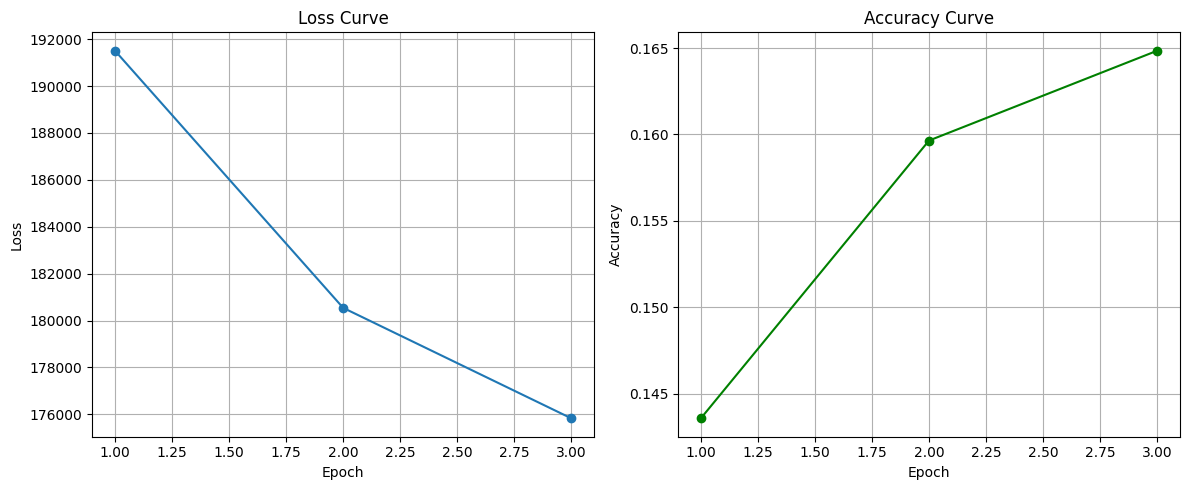

In [15]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, marker='o', label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, marker='o', color='green', label="Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)

plt.tight_layout()
plt.show()
